In [ ]:
!pip install plotly pandas 


In [1]:
import sqlite3
import pandas as pd
import plotly.express as px

In [2]:
conn = sqlite3.connect("badge_attendance.db")


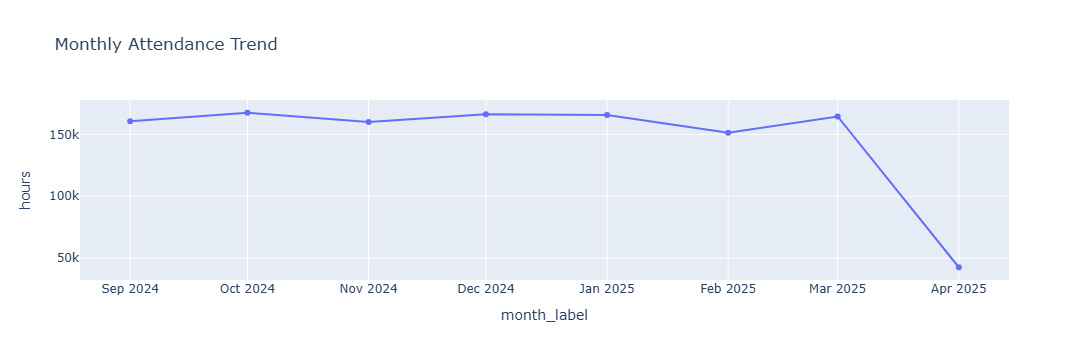

In [3]:
query = """
SELECT
    c.year,
    c.month,
    SUM(f.total_hours) as hours
FROM fact_attendance_daily f
JOIN dim_calendar c
ON f.date_id = c.date_id
GROUP BY c.year, c.month
ORDER BY c.year, c.month
"""

df_month = pd.read_sql(query, conn)

df_month["month_label"] = df_month["year"].astype(str) + "-" + df_month["month"].astype(str)

fig = px.line(df_month,
              x="month_label",
              y="hours",
              title="Monthly Attendance Trend",
              markers=True)

fig.show()


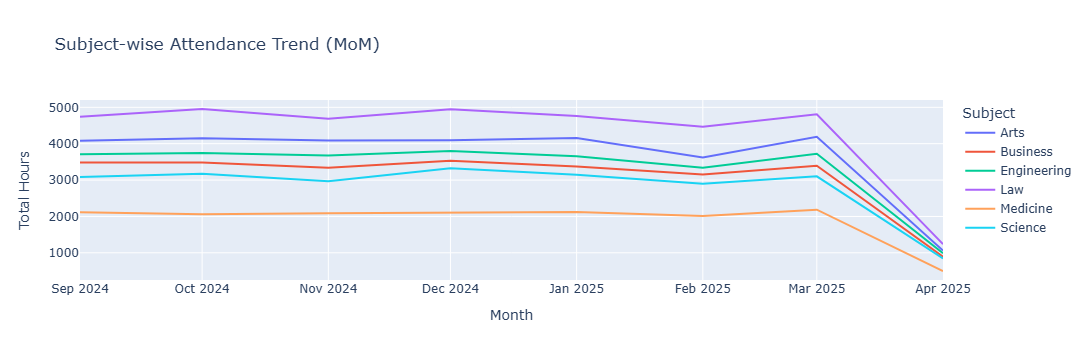

In [4]:
query = """
SELECT
    c.year,
    c.month,
    t.department AS subject,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_calendar c
    ON f.date_id = c.date_id
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY c.year, c.month, t.department
ORDER BY c.year, c.month;
"""

df = pd.read_sql(query, conn)

df["month_label"] = df["year"].astype(str) + "-" + df["month"].astype(str)

fig = px.line(
    df,
    x="month_label",
    y="total_hours",
    color="subject",
    title="Subject-wise Attendance Trend (MoM)"
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Total Hours",
    legend_title="Subject"
)

fig.show()


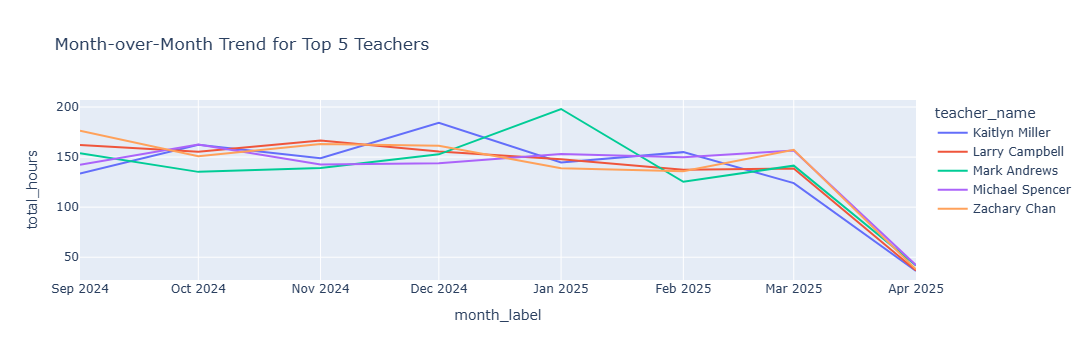

In [5]:
query = """
SELECT
    c.year,
    c.month,
    t.name AS teacher_name,
    SUM(f.total_hours) AS total_hours
FROM fact_attendance_daily f
JOIN dim_calendar c
    ON f.date_id = c.date_id
JOIN dim_teachers t
    ON f.badge_id = t.badge_id
GROUP BY c.year, c.month, t.name
ORDER BY c.year, c.month;
"""

df = pd.read_sql(query, conn)

df["month_label"] = df["year"].astype(str) + "-" + df["month"].astype(str)

# Pick only top 5 teachers overall for cleaner chart
top_teachers = (
    df.groupby("teacher_name")["total_hours"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
      .index
)

df_top = df[df["teacher_name"].isin(top_teachers)]

fig = px.line(
    df_top,
    x="month_label",
    y="total_hours",
    color="teacher_name",
    title="Month-over-Month Trend for Top 5 Teachers"
)

fig.show()
